# Building and running

In [1]:
import pandas as pd
import numpy as np
import cv2
import hashlib

from tensorflow import keras

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Load and prepare dataset
The dataset is composed by:
 * CSV with the labeling
 * Image folder with all the images normalized

In [2]:
dataset_folder = 'normalized_data_set_diagrams/'
labeled_csv = 'csv/scrapped_images.csv'

In [3]:
map_to_name = {}


def load_dataset(dataset_folder_path, csv_path):
    """Loads a dataset of images
        - dataset_folder_path is the path of the folder that contains the images
        - csv_path is the path of the CSV file that contains the labels of the images
        Returns: X_data, y_labeled
        - X_data is a numpy.ndarray containing the pixel data of an image X
        - y_labeled is a numpy.ndarray containing an int, the label Y for the image X in that index
    """
    X_data = []

    data = pd.read_csv(csv_path, dtype={"Name": str, "Category": np.uint8})

    for image_name in data.Name:
        img = cv2.imread(dataset_folder_path + image_name, cv2.IMREAD_COLOR)
        hash = hashlib.sha1(img).hexdigest()[:15]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        map_to_name[hash] = image_name
        X_data.append(img)

    X_data = np.array(X_data)
    y_labeled = np.array(data.Category)

    print("Data loaded\n", data)
    return X_data, y_labeled

In [4]:
def preprocess_data(x, y, m):
    """Pre-processes the data for the model
        - x is a numpy.ndarray of shape (m, 224, 224, 3) containing
         a list of image pixels, where m is the number of images
        - y is a numpy.ndarray of shape (m,) containing
         the labels for x
        - m is the number of categories in the classifier
        Returns: X_p, Y_p
        - X_p is a numpy.ndarray containing the preprocessed X
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_p = keras.applications.densenet.preprocess_input(x)

    y_p = keras.utils.to_categorical(y, m)

    return X_p, y_p

In [5]:
X_full, y_full = load_dataset(dataset_folder, labeled_csv)
X_full_p, y_full_p = preprocess_data(X_full, y_full, 7)

Data loaded
                      Name  Category
0     7a668879d103ba8.jpg         1
1     4bab7d342c24e3f.jpg         1
2     d6c5e6d46cbbb26.jpg         1
3     e215c30192cc297.jpg         1
4     0fd2b9ef096d9cb.jpg         1
...                   ...       ...
5551  d2254621efd8d52.jpg         0
5552  de2268621d5e911.jpg         0
5553  90fe34f3f8107ee.jpg         0
5554  f065035fafcf430.jpg         0
5555  30efd0c8a1649e1.jpg         0

[5556 rows x 2 columns]


## Building DenseNet169

In [6]:
input_shape_densenet = (224, 224, 3)

In [7]:
def build_network(trainable: bool):
    """Pre-processes the data for the model
        Returns: densenet_model
        - densenet_model is a
    """
    densenet_model = keras.applications.DenseNet169(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape_densenet,
        pooling=None
    )
    densenet_model.trainable = trainable
    if trainable:
        for layer in densenet_model.layers:
            if 'conv5' in layer.name:
                layer.trainable = True
            else:
                layer.trainable = False

    return densenet_model

### Add new layers

In [8]:
def add_extra_layers(densenet_model, layer_size: int, dropout: bool, number_of_layers: int):
    """Add extra layers to a Keras model for transfer learning.
        - densenet_model is a pre-trained Keras model with input (224, 224, 3)
        - layer_size is an int, the size of the first Dense layer
        - dropout is a bool, indicating if a Dropout layer will be added
          between Dense layers
        Returns: model
        - model a Keras model with the layer added
    """
    initializer = keras.initializers.he_normal(seed=32)
    inputs = keras.Input(shape=input_shape_densenet)

    layer = densenet_model(inputs)
    layer = keras.layers.Flatten()(layer)

    layer = keras.layers.BatchNormalization()(layer)

    for n in range(1, number_of_layers+1):
        layer = keras.layers.Dense(units=layer_size/n,
                                   activation='relu',
                                   kernel_initializer=initializer
                                   )(layer)
        if dropout:
            layer = keras.layers.Dropout(0.5)(layer)

        layer = keras.layers.BatchNormalization()(layer)


    layer = keras.layers.Dense(units=7,
                               activation='softmax',
                               kernel_initializer=initializer
                               )(layer)

    model = keras.models.Model(inputs, outputs=layer)
    model.summary()

    return model

### Validating the results

In [9]:
def train_with_k_fold_cross_validation(n_folds: int, layer_size: int, trainable: bool, dropout: bool, number_of_layers: int):
    """Create and train a DenseNet model n_folds times with a different training/validation partition data.
        - n_folds the number of times the model will be trained
        - layer_size is an int, the size of the first Dense layer
        - trainable ia a bool, indicating if the last layer of the original model cold be re-trainable
        - dropout is a bool, indicating if a Dropout layer will be added
          between Dense layers
        Returns: histories
        - histories a list of size n_folds with the detailed training history of each attempt
    """
    histories = []
    for fold in range(n_folds):
        network = build_network(trainable)
        network = add_extra_layers(network, layer_size, dropout, number_of_layers)
        network.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])

        X_train, X_val, y_train, y_val = train_test_split(X_full_p, y_full_p, test_size=0.2, random_state=fold * 5)
        history = network.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
        del network
        histories.append(history)

    return histories

In [10]:
def train_with_simple_holdout_validation(X_train, X_val, y_train, y_val):
    network = build_network(True)
    network = add_extra_layers(network, 128, True, 1)
    network.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])

    history = network.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)

    network.save('diagrams.h5')
    return network

### Running the model

In [11]:
history_ini = []
folds = 4
max_layers = 3
layers = [512, 256, 128, 64]
for l in range(max_layers):
    h = np.array(train_with_k_fold_cross_validation(folds, 128, True, True, l))
    history_ini.append(h)

Metal device set to: Apple M1 Pro


2022-07-01 03:42:34.827201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-01 03:42:34.827406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 7)                 570759    
                                                                 
Total params: 13,539,783
Trainable params: 6,647,431
Non-trainable params: 6,892,352
__________________________________________

2022-07-01 03:42:42.151358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-01 03:42:47.894207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 1.3104 - accuracy: 0.8672

2022-07-01 03:43:35.510742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 64s 397ms/step - loss: 1.3104 - accuracy: 0.8672 - val_loss: 2.2000 - val_accuracy: 0.8948
Epoch 2/10
139/139 [==============================] - 50s 362ms/step - loss: 0.6981 - accuracy: 0.9406 - val_loss: 0.9836 - val_accuracy: 0.9379
Epoch 3/10
139/139 [==============================] - 50s 361ms/step - loss: 0.4996 - accuracy: 0.9615 - val_loss: 1.1552 - val_accuracy: 0.9397
Epoch 4/10
139/139 [==============================] - 50s 358ms/step - loss: 0.3450 - accuracy: 0.9705 - val_loss: 1.1894 - val_accuracy: 0.9281
Epoch 5/10
139/139 [==============================] - 50s 356ms/step - loss: 0.3467 - accuracy: 0.9685 - val_loss: 1.5678 - val_accuracy: 0.9424
Epoch 6/10
139/139 [==============================] - 49s 356ms/step - loss: 0.3135 - accuracy: 0.9755 - val_loss: 1.2610 - val_accuracy: 0.9442
Epoch 7/10
139/139 [==============================] - 50s 358ms/step - loss: 0.2795 - accuracy: 0.9793 - val_loss: 1.0787 - val_accuracy: 0.9

2022-07-01 03:51:27.893821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 1.2714 - accuracy: 0.8670

2022-07-01 03:52:16.504415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 65s 400ms/step - loss: 1.2714 - accuracy: 0.8670 - val_loss: 2.2384 - val_accuracy: 0.8822
Epoch 2/10
139/139 [==============================] - 52s 373ms/step - loss: 0.7508 - accuracy: 0.9365 - val_loss: 1.4627 - val_accuracy: 0.9083
Epoch 3/10
139/139 [==============================] - 50s 362ms/step - loss: 0.4823 - accuracy: 0.9584 - val_loss: 0.9669 - val_accuracy: 0.9415
Epoch 4/10
139/139 [==============================] - 51s 363ms/step - loss: 0.3628 - accuracy: 0.9678 - val_loss: 1.1263 - val_accuracy: 0.9397
Epoch 5/10
139/139 [==============================] - 50s 362ms/step - loss: 0.4414 - accuracy: 0.9678 - val_loss: 1.0367 - val_accuracy: 0.9487
Epoch 6/10
139/139 [==============================] - 50s 361ms/step - loss: 0.2699 - accuracy: 0.9768 - val_loss: 1.0676 - val_accuracy: 0.9451
Epoch 7/10
139/139 [==============================] - 50s 359ms/step - loss: 0.3214 - accuracy: 0.9779 - val_loss: 1.4044 - val_accuracy: 0.9

2022-07-01 04:00:19.831287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.8668

2022-07-01 04:01:10.994475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 70s 420ms/step - loss: 1.3559 - accuracy: 0.8668 - val_loss: 3.2872 - val_accuracy: 0.8570
Epoch 2/10
139/139 [==============================] - 51s 367ms/step - loss: 0.6553 - accuracy: 0.9431 - val_loss: 0.9922 - val_accuracy: 0.9451
Epoch 3/10
139/139 [==============================] - 50s 362ms/step - loss: 0.4454 - accuracy: 0.9602 - val_loss: 1.2441 - val_accuracy: 0.9308
Epoch 4/10
139/139 [==============================] - 51s 367ms/step - loss: 0.3822 - accuracy: 0.9667 - val_loss: 1.3576 - val_accuracy: 0.9487
Epoch 5/10
139/139 [==============================] - 50s 359ms/step - loss: 0.3591 - accuracy: 0.9723 - val_loss: 1.4414 - val_accuracy: 0.9299
Epoch 6/10
139/139 [==============================] - 51s 365ms/step - loss: 0.3556 - accuracy: 0.9728 - val_loss: 1.0986 - val_accuracy: 0.9649
Epoch 7/10
139/139 [==============================] - 50s 359ms/step - loss: 0.4045 - accuracy: 0.9748 - val_loss: 0.8851 - val_accuracy: 0.9

2022-07-01 04:09:16.404967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 1.2674 - accuracy: 0.8659

2022-07-01 04:10:10.346598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 73s 434ms/step - loss: 1.2674 - accuracy: 0.8659 - val_loss: 2.3290 - val_accuracy: 0.8993
Epoch 2/10
139/139 [==============================] - 51s 370ms/step - loss: 0.7202 - accuracy: 0.9379 - val_loss: 1.4069 - val_accuracy: 0.9245
Epoch 3/10
139/139 [==============================] - 51s 365ms/step - loss: 0.5722 - accuracy: 0.9563 - val_loss: 0.9268 - val_accuracy: 0.9532
Epoch 4/10
139/139 [==============================] - 51s 366ms/step - loss: 0.2878 - accuracy: 0.9737 - val_loss: 0.5908 - val_accuracy: 0.9604
Epoch 5/10
139/139 [==============================] - 51s 365ms/step - loss: 0.2815 - accuracy: 0.9743 - val_loss: 0.7704 - val_accuracy: 0.9604
Epoch 6/10
139/139 [==============================] - 50s 360ms/step - loss: 0.3966 - accuracy: 0.9757 - val_loss: 1.1939 - val_accuracy: 0.9505
Epoch 7/10
139/139 [==============================] - 50s 360ms/step - loss: 0.2735 - accuracy: 0.9797 - val_loss: 1.5676 - val_accuracy: 0.9

2022-07-01 04:18:13.949807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8882

2022-07-01 04:19:16.161182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 84s 493ms/step - loss: 0.3593 - accuracy: 0.8882 - val_loss: 0.1831 - val_accuracy: 0.9496
Epoch 2/10
139/139 [==============================] - 58s 415ms/step - loss: 0.1200 - accuracy: 0.9667 - val_loss: 0.1208 - val_accuracy: 0.9658
Epoch 3/10
139/139 [==============================] - 56s 405ms/step - loss: 0.0680 - accuracy: 0.9800 - val_loss: 0.0885 - val_accuracy: 0.9775
Epoch 4/10
139/139 [==============================] - 56s 402ms/step - loss: 0.0454 - accuracy: 0.9869 - val_loss: 0.1149 - val_accuracy: 0.9703
Epoch 5/10
139/139 [==============================] - 56s 403ms/step - loss: 0.0497 - accuracy: 0.9858 - val_loss: 0.1111 - val_accuracy: 0.9703
Epoch 6/10
139/139 [==============================] - 56s 401ms/step - loss: 0.0267 - accuracy: 0.9937 - val_loss: 0.1031 - val_accuracy: 0.9721
Epoch 7/10
139/139 [==============================] - 56s 400ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 0.1024 - val_accuracy: 0.9

2022-07-01 04:28:11.063662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8864

2022-07-01 04:29:11.732349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 84s 505ms/step - loss: 0.3596 - accuracy: 0.8864 - val_loss: 0.2058 - val_accuracy: 0.9371
Epoch 2/10
139/139 [==============================] - 58s 417ms/step - loss: 0.1105 - accuracy: 0.9665 - val_loss: 0.0894 - val_accuracy: 0.9712
Epoch 3/10
139/139 [==============================] - 58s 417ms/step - loss: 0.0670 - accuracy: 0.9802 - val_loss: 0.1428 - val_accuracy: 0.9595
Epoch 4/10
139/139 [==============================] - 58s 414ms/step - loss: 0.0570 - accuracy: 0.9820 - val_loss: 0.0956 - val_accuracy: 0.9712
Epoch 5/10
139/139 [==============================] - 57s 407ms/step - loss: 0.0417 - accuracy: 0.9878 - val_loss: 0.0797 - val_accuracy: 0.9712
Epoch 6/10
139/139 [==============================] - 57s 408ms/step - loss: 0.0417 - accuracy: 0.9881 - val_loss: 0.1345 - val_accuracy: 0.9532
Epoch 7/10
139/139 [==============================] - 56s 406ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.0845 - val_accuracy: 0.9

2022-07-01 04:38:15.377928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8852

2022-07-01 04:39:27.067416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 96s 614ms/step - loss: 0.3603 - accuracy: 0.8852 - val_loss: 0.1326 - val_accuracy: 0.9613
Epoch 2/10
139/139 [==============================] - 70s 505ms/step - loss: 0.1214 - accuracy: 0.9658 - val_loss: 0.0901 - val_accuracy: 0.9667
Epoch 3/10
139/139 [==============================] - 71s 514ms/step - loss: 0.0642 - accuracy: 0.9824 - val_loss: 0.0862 - val_accuracy: 0.9757
Epoch 4/10
139/139 [==============================] - 70s 502ms/step - loss: 0.0641 - accuracy: 0.9797 - val_loss: 0.1108 - val_accuracy: 0.9640
Epoch 5/10
139/139 [==============================] - 69s 497ms/step - loss: 0.0357 - accuracy: 0.9914 - val_loss: 0.0754 - val_accuracy: 0.9748
Epoch 6/10
139/139 [==============================] - 69s 494ms/step - loss: 0.0370 - accuracy: 0.9883 - val_loss: 0.0913 - val_accuracy: 0.9703
Epoch 7/10
139/139 [==============================] - 69s 494ms/step - loss: 0.0264 - accuracy: 0.9941 - val_loss: 0.1003 - val_accuracy: 0.9

2022-07-01 04:50:27.724299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8902

2022-07-01 04:51:36.061411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 95s 568ms/step - loss: 0.3584 - accuracy: 0.8902 - val_loss: 0.2180 - val_accuracy: 0.9424
Epoch 2/10
139/139 [==============================] - 62s 445ms/step - loss: 0.1191 - accuracy: 0.9658 - val_loss: 0.1023 - val_accuracy: 0.9721
Epoch 3/10
139/139 [==============================] - 61s 439ms/step - loss: 0.0618 - accuracy: 0.9833 - val_loss: 0.0741 - val_accuracy: 0.9757
Epoch 4/10
139/139 [==============================] - 61s 441ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.1304 - val_accuracy: 0.9667
Epoch 5/10
139/139 [==============================] - 60s 433ms/step - loss: 0.0419 - accuracy: 0.9876 - val_loss: 0.0840 - val_accuracy: 0.9802
Epoch 6/10
139/139 [==============================] - 60s 431ms/step - loss: 0.0303 - accuracy: 0.9921 - val_loss: 0.0793 - val_accuracy: 0.9793
Epoch 7/10
139/139 [==============================] - 61s 438ms/step - loss: 0.0304 - accuracy: 0.9917 - val_loss: 0.1023 - val_accuracy: 0.9

2022-07-01 05:01:13.954006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.7786

2022-07-01 05:02:31.733121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 103s 642ms/step - loss: 0.6989 - accuracy: 0.7786 - val_loss: 0.3481 - val_accuracy: 0.9020
Epoch 2/10
139/139 [==============================] - 72s 520ms/step - loss: 0.2672 - accuracy: 0.9363 - val_loss: 0.1521 - val_accuracy: 0.9604
Epoch 3/10
139/139 [==============================] - 71s 504ms/step - loss: 0.1657 - accuracy: 0.9572 - val_loss: 0.1694 - val_accuracy: 0.9487
Epoch 4/10
139/139 [==============================] - 71s 509ms/step - loss: 0.1147 - accuracy: 0.9696 - val_loss: 0.1594 - val_accuracy: 0.9586
Epoch 5/10
139/139 [==============================] - 70s 502ms/step - loss: 0.0981 - accuracy: 0.9768 - val_loss: 0.0981 - val_accuracy: 0.9730
Epoch 6/10
139/139 [==============================] - 70s 500ms/step - loss: 0.0611 - accuracy: 0.9854 - val_loss: 0.1129 - val_accuracy: 0.9721
Epoch 7/10
139/139 [==============================] - 69s 499ms/step - loss: 0.0560 - accuracy: 0.9863 - val_loss: 0.1493 - val_accuracy: 0.

2022-07-01 05:13:42.408734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.7754

2022-07-01 05:15:01.541707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 113s 659ms/step - loss: 0.7373 - accuracy: 0.7754 - val_loss: 0.1644 - val_accuracy: 0.9514
Epoch 2/10
139/139 [==============================] - 64s 461ms/step - loss: 0.2794 - accuracy: 0.9284 - val_loss: 0.1047 - val_accuracy: 0.9712
Epoch 3/10
139/139 [==============================] - 62s 446ms/step - loss: 0.1682 - accuracy: 0.9606 - val_loss: 0.1328 - val_accuracy: 0.9604
Epoch 4/10
139/139 [==============================] - 63s 452ms/step - loss: 0.1308 - accuracy: 0.9658 - val_loss: 0.0774 - val_accuracy: 0.9784
Epoch 5/10
139/139 [==============================] - 62s 446ms/step - loss: 0.1024 - accuracy: 0.9728 - val_loss: 0.0830 - val_accuracy: 0.9721
Epoch 6/10
139/139 [==============================] - 64s 463ms/step - loss: 0.0832 - accuracy: 0.9779 - val_loss: 0.0766 - val_accuracy: 0.9757
Epoch 7/10
139/139 [==============================] - 62s 443ms/step - loss: 0.0730 - accuracy: 0.9802 - val_loss: 0.0824 - val_accuracy: 0.

2022-07-01 05:25:03.865030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.7743

2022-07-01 05:26:35.842581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 122s 750ms/step - loss: 0.7251 - accuracy: 0.7743 - val_loss: 0.1745 - val_accuracy: 0.9487
Epoch 2/10
139/139 [==============================] - 71s 514ms/step - loss: 0.2792 - accuracy: 0.9318 - val_loss: 0.2049 - val_accuracy: 0.9308
Epoch 3/10
139/139 [==============================] - 71s 509ms/step - loss: 0.1705 - accuracy: 0.9557 - val_loss: 0.1239 - val_accuracy: 0.9676
Epoch 4/10
139/139 [==============================] - 70s 506ms/step - loss: 0.1085 - accuracy: 0.9732 - val_loss: 0.1100 - val_accuracy: 0.9685
Epoch 5/10
139/139 [==============================] - 70s 507ms/step - loss: 0.0755 - accuracy: 0.9822 - val_loss: 0.0795 - val_accuracy: 0.9784
Epoch 6/10
139/139 [==============================] - 71s 508ms/step - loss: 0.0508 - accuracy: 0.9896 - val_loss: 0.1093 - val_accuracy: 0.9649
Epoch 7/10
139/139 [==============================] - 69s 499ms/step - loss: 0.0655 - accuracy: 0.9827 - val_loss: 0.1146 - val_accuracy: 0.

2022-07-01 05:37:56.096922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.7851

2022-07-01 05:39:24.198399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 127s 737ms/step - loss: 0.6957 - accuracy: 0.7851 - val_loss: 0.2263 - val_accuracy: 0.9379
Epoch 2/10
139/139 [==============================] - 71s 507ms/step - loss: 0.2686 - accuracy: 0.9343 - val_loss: 0.1399 - val_accuracy: 0.9586
Epoch 3/10
139/139 [==============================] - 68s 490ms/step - loss: 0.1622 - accuracy: 0.9584 - val_loss: 0.1116 - val_accuracy: 0.9739
Epoch 4/10
139/139 [==============================] - 68s 489ms/step - loss: 0.1143 - accuracy: 0.9734 - val_loss: 0.1672 - val_accuracy: 0.9487
Epoch 5/10
139/139 [==============================] - 68s 491ms/step - loss: 0.0974 - accuracy: 0.9741 - val_loss: 0.0974 - val_accuracy: 0.9694
Epoch 6/10
139/139 [==============================] - 68s 490ms/step - loss: 0.0865 - accuracy: 0.9773 - val_loss: 0.1089 - val_accuracy: 0.9676
Epoch 7/10
139/139 [==============================] - 67s 484ms/step - loss: 0.0689 - accuracy: 0.9809 - val_loss: 0.1109 - val_accuracy: 0.

### Showing the results

In [12]:
def show_and_predict_img(name: str, model):
    img = cv2.imread('test/' + name, cv2.IMREAD_ANYCOLOR)
    im = np.array([img])
    im = keras.applications.densenet.preprocess_input(im)

    cv2.imshow('img', img)
    cv2.waitKey(0)
    return model.predict(im)

In [13]:
def get_history_mean(k_history, prop: str):
    val_acc = [h.history[prop] for h in k_history]
    mean = np.mean(val_acc, axis=0)
    return mean

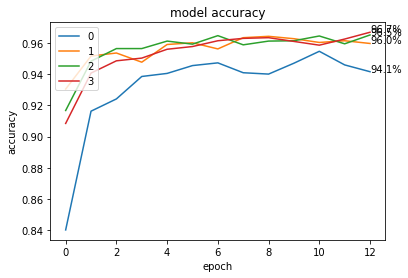

In [19]:
means = map(get_history_mean, history, ['val_accuracy'] * len(history))

plot_model_accuracy(means, ['0', '1', '2', '3'])

In [14]:
def plot_model_accuracy(accs, losses, legends):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    for acc in accs:
        plt.plot(acc)
        l = len(acc) - 1
        plt.text(l, acc[l], "{:.1f}%".format(acc[l] * 100))
    plt.legend(legends, loc='lower right')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.subplot(1,2,2)
    for loss in losses:
        plt.plot(loss)
        l = len(loss) - 1
        plt.text(l, loss[l], "{:.1f}%".format(loss[l] * 100))
    plt.legend(legends, loc='upper right')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('number_of_layers.png')
    plt.show()

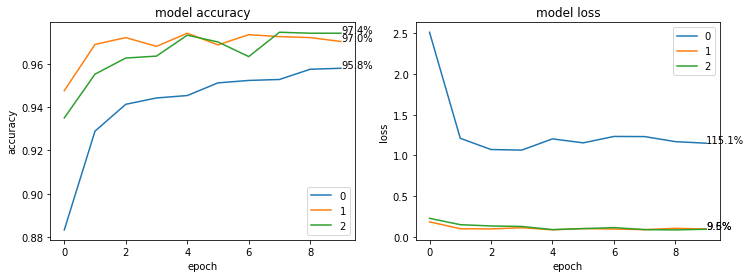

In [15]:
acc = map(get_history_mean, history_ini, ['val_accuracy'] * len(history_ini))
loss = map(get_history_mean, history_ini, ['val_loss'] * len(history_ini))

plot_model_accuracy(acc, loss, [0, 1, 2, 3])

### Validating the failed cases

In [14]:
def validate_failed(model, X, y, X_original, show_image: bool):
    prob = model.predict(X)
    predictions = prob.argmax(axis=-1)
    expected_y = y.argmax(axis=-1)
    failed = []
    for i in range(len(predictions)):
        if predictions[i] != expected_y[i]:
            failed.append(i)
            if show_image:
                hash = hashlib.sha1(X_original[i]).hexdigest()[:15]
                name = map_to_name[hash]
                print(
                    f'\r{name} Expected {expected_y[i]} ({prob[i][expected_y[i]]}) but got {predictions[i]} ({prob[i][predictions[i]]})',
                    flush=True, end=' ' * 50)
                cv2.imshow('Failed', X_val[i])
                cv2.imshow('Original', X_original[i])
                cv2.waitKey(0)
    len(failed)

    return failed

In [12]:
seed = 25

X_train, X_val, y_train, y_val = train_test_split(X_full_p, y_full_p, test_size=0.2, random_state=seed)
_, X_original, _, _ = train_test_split(X_full, y_full, test_size=0.2, random_state=seed)

model = train_with_simple_holdout_validation(X_train, X_val, y_train, y_val)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_1 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 81536)            326144    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               10436736  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                           

2022-07-15 03:44:03.702553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8891

2022-07-15 03:44:58.073982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 71s 453ms/step - loss: 0.3539 - accuracy: 0.8891 - val_loss: 0.1651 - val_accuracy: 0.9442
Epoch 2/10
139/139 [==============================] - 57s 410ms/step - loss: 0.1256 - accuracy: 0.9620 - val_loss: 0.1471 - val_accuracy: 0.9550
Epoch 3/10
139/139 [==============================] - 56s 404ms/step - loss: 0.0688 - accuracy: 0.9811 - val_loss: 0.1170 - val_accuracy: 0.9658
Epoch 4/10
139/139 [==============================] - 56s 405ms/step - loss: 0.0487 - accuracy: 0.9858 - val_loss: 0.1223 - val_accuracy: 0.9685
Epoch 5/10
139/139 [==============================] - 62s 448ms/step - loss: 0.0419 - accuracy: 0.9883 - val_loss: 0.1018 - val_accuracy: 0.9739
Epoch 6/10
139/139 [==============================] - 58s 416ms/step - loss: 0.0272 - accuracy: 0.9935 - val_loss: 0.0694 - val_accuracy: 0.9829
Epoch 7/10
139/139 [==============================] - 62s 443ms/step - loss: 0.0308 - accuracy: 0.9910 - val_loss: 0.1066 - val_accuracy: 0.9

In [25]:
failed = validate_failed(model, X_val, y_val, X_original, True)
len(failed)

2022-07-01 03:20:03.156236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


a5aa86af1cf8544.jpg Expected 0 (0.0010093660093843937) but got 6 (0.6144306063652039)                                                   

80

### Testing new cases

In [ ]:
loaded_model = keras.models.load_model('diagrams_v9.h5')

In [14]:
show_and_predict_img('conceptual.jpg', loaded_model)

array([[0.00571571, 0.16076495, 0.03779309, 0.16143267, 0.58737206,
        0.01790639, 0.01244646, 0.01656868]], dtype=float32)